In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import random
#import deque
from pyvirtualdisplay import Display
import cv2
import warnings
warnings.simplefilter('ignore')

In [38]:
class ExperienceReplay():
    
    def __init__(self, capacity, device):
        self.memory = []
        self.capacity = capacity
        self.device = device
        
    def push(self, experience):
        self.memory.append(experience)
        if len(self.memory) > self.capacity:
            self.memory.pop(0)

    def sample(self, batch_size):
        experiences = random.sample(self.memory, batch_size)
        states = torch.from_numpy(np.vstack([e[0] for e in experiences if e is not None])).float().to(self.device)
        actions = torch.from_numpy(np.vstack([e[1] for e in experiences if e is not None])).long().to(self.device)
        rewards = torch.from_numpy(np.vstack([e[2] for e in experiences if e is not None])).float().to(self.device)
        next_states = torch.from_numpy(np.vstack([e[3] for e in experiences if e is not None])).float().to(self.device)
        dones = torch.from_numpy(np.vstack([e[4] for e in experiences if e is not None]).astype(np.uint8)).float().to(self.device)
        return states, actions, rewards, next_states, dones

In [39]:
class Network(nn.Module):
    
    def __init__(self, state_dim, n_actions):
        super(Network, self).__init__()
        self.fc1 = nn.Linear(state_dim, 512)
        self.fc2 = nn.Linear(512, 512)
        self.fc3 = nn.Linear(512, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [46]:
class Agent():
    
    def __init__(self, state_dim, n_actions, capacity, batch_size, device):
        self.state_dim = state_dim
        self.n_actions = n_actions
        self.device = device
        self.batch_size = batch_size
        self.buffer = ExperienceReplay(capacity, device)
        self.target_network = Network(state_dim, n_actions).to(self.device)
        self.local_network = Network(state_dim, n_actions).to(self.device)
        self.optimizer = torch.optim.Adam(self.local_network.parameters(), lr=5e-4)
        self.criterion = nn.MSELoss().to(self.device)
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_decay = 0.995
        self.epsilon_min = 0.01
        self.interpolation = 1e-3
        self.time_step_counter = 0
        
    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    
    def select_action(self, state):
        state = torch.tensor(state, dtype=torch.float32, device=self.device)
        
        self.local_network.eval()
        with torch.no_grad():
            action_values = self.local_network.forward(state)
        self.local_network.train()

        if random.random() > self.epsilon:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.n_actions))
            
    def soft_update(self, local_model, target_model, interpolation_paramater):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(interpolation_paramater * local_param.data + (1.0 - interpolation_paramater) * target_param)


    def learn(self, experience):
        states, actions, rewards, next_states, dones = experience
        a = self.target_network(next_states)
        #print(self.target_network(next_states).detach().mean(1).size())
        next_q_target = self.target_network(next_states).detach().mean(1).unsqueeze(1)
        
        #action_probabilities = self.local_network(next_states)  # Shape: [128, 18]
        #next_q_values = self.target_network(next_states).detach()  # Shape: [128, 18]
        #expected_q_values = (action_probabilities * next_q_values).sum(dim=1, keepdim=True)  # Shape: [128, 1]
        #q_target = rewards + (self.gamma * expected_q_values * (1 - dones))  # Shape: [128, 1]
        
        q_target = rewards + (self.gamma * next_q_target * (1-dones))

        q_expected = self.local_network(states).gather(1, actions)
        # gather method to select only the Q-values corresponding to the actions that were actually taken
        
        loss = self.criterion(q_expected, q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.local_network, self.target_network, self.interpolation)


    def step(self, state, action, reward, next_state, done):
        self.buffer.push([state, action, reward, next_state, done])
        self.time_step_counter = (self.time_step_counter + 1) % 4
        if self.time_step_counter == 0:
            if len(self.buffer.memory) > self.batch_size:
                experiences = self.buffer.sample(self.batch_size)
                self.learn(experiences)

In [41]:
env_name = 'ALE/Boxing-v5'
env = gym.make(env_name, obs_type='ram')

state_shape = env.observation_space.shape
state_size = env.observation_space.shape[0]
n_actions = env.action_space.n


device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
batch_size = 128

In [42]:
device

device(type='mps')

In [43]:
torch.mps.empty_cache()

In [48]:
agent = Agent(state_size, n_actions, capacity=1e5, batch_size=batch_size, device=device)

In [49]:
number_of_episodes = 5000
max_number_time_steps_per_episode = 1000
scores_list = []

for episode in range(1, number_of_episodes+1):
    episode_score = []
    done = False
    state, _ = env.reset()
    score = 0
    time_step = 0
    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _, _ = env.step(action)
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        episode_score.append(score)
        time_step += 1
        if time_step == max_number_time_steps_per_episode:
            break
    scores_list.append(sum(episode_score)/len(episode_score))
    #scores_on_100_episodes.append(score)
    agent.update_epsilon()
    print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, sum(episode_score)/len(episode_score)), end = "")
    if episode % 100 == 0:
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, sum(episode_score)/len(episode_score)))
    if sum(episode_score)/len(episode_score) >= 200.0:
        print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(episode - 100, sum(episode_score)/len(episode_score)))
        break

Episode 100	Average Score: -2.39
Episode 200	Average Score: 7.1213
Episode 300	Average Score: 8.305
Episode 400	Average Score: 7.749
Episode 500	Average Score: 16.18
Episode 600	Average Score: 22.84
Episode 700	Average Score: 30.83
Episode 800	Average Score: 0.438
Episode 900	Average Score: 14.64
Episode 1000	Average Score: 24.42
Episode 1100	Average Score: 3.678
Episode 1200	Average Score: 24.75
Episode 1300	Average Score: 18.01
Episode 1400	Average Score: 25.95
Episode 1500	Average Score: 28.82
Episode 1600	Average Score: 33.67
Episode 1700	Average Score: 20.01
Episode 1800	Average Score: 35.88
Episode 1900	Average Score: 7.653
Episode 2000	Average Score: 23.37
Episode 2100	Average Score: 9.266
Episode 2200	Average Score: 41.40
Episode 2300	Average Score: 21.91
Episode 2400	Average Score: 7.774
Episode 2500	Average Score: 24.45
Episode 2600	Average Score: 8.301
Episode 2700	Average Score: 34.66
Episode 2800	Average Score: 4.952
Episode 2900	Average Score: 22.64
Episode 3000	Average S

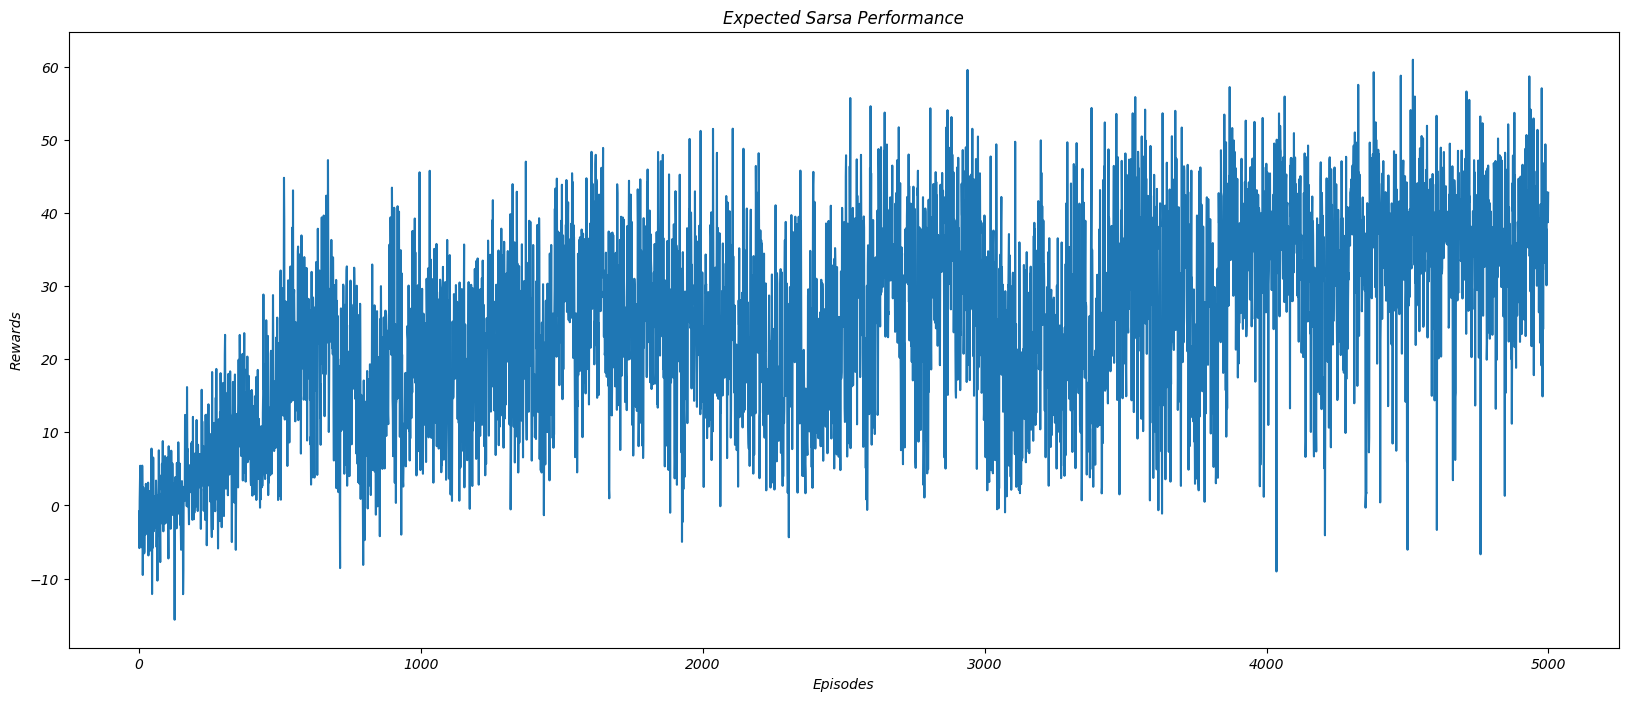

In [57]:
fig = plt.figure(figsize=(20, 8), dpi=100)
plt.title('Expected Sarsa Performance')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.plot([x for x in range(len(scores_list))], scores_list)

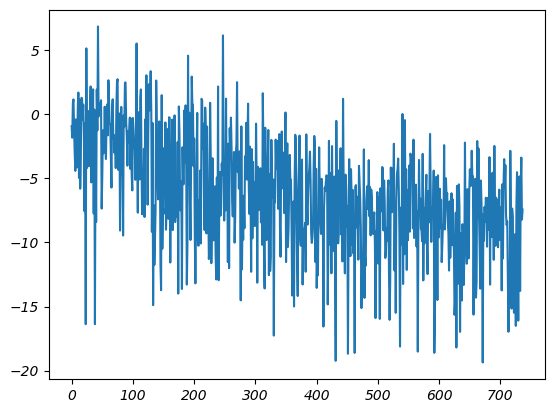

In [36]:
plt.plot([x for x in range(len(scores_list))], scores_list)

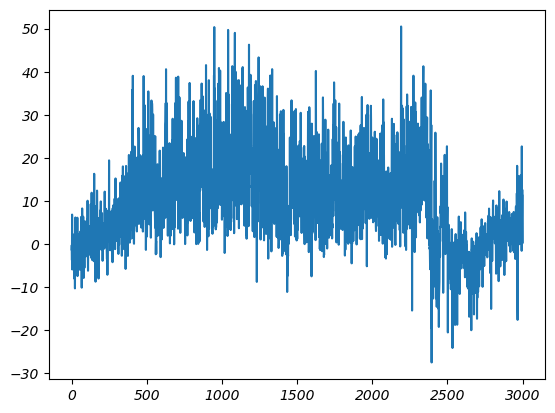

In [31]:
plt.plot([x for x in range(len(scores_list))], scores_list)

In [58]:
def create_virtual_display():
    display = Display(visible=0, size=(1400, 900))
    display.start()
    return display

frames = [] 

def watch_agent(env_name):
    env = gym.make(env_name, obs_type='ram', render_mode = 'rgb_array')
    state, _ = env.reset()
    total_reward = 0
    print(state.shape)
    while True:
        frames.append(env.render()) 
        action = agent.select_action(state)
        state, reward, done, _, _ = env.step(action)
        total_reward += reward

        if done:
            break

    print("Total reward:", total_reward)
    env.close()
    

def save_video(frames, video_name='q_learning_self_agent_video', fps=30):
    height, width, _ = frames[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(video_name + '.mp4', fourcc, fps, (width, height))

    for frame in frames:
        out.write(frame)

    out.release()

watch_agent(env_name)
save_video(frames, video_name='expected_sarsa_boxing', fps=30)

(128,)
Total reward: 87.0


In [17]:
torch.save(agent.local_network.state_dict(), '/Users/desidero/Desktop/boxing.pth')